<a href="https://colab.research.google.com/github/LukasEder1/StationarityPrediction/blob/main/Stationary_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup
Code Adapted from: https://github.com/nlp-with-transformers/notebooks

In [1]:
!pip install datasets
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.7 MB/s eta 0:00:00


In [2]:
import torch

cuda_available = torch.cuda.is_available()
device = torch.device('cuda' if cuda_available else 'cpu')
print(f'cuda_available: {cuda_available}, device: {device}')

cuda_available: True, device: cuda


In [3]:
!git clone https://github.com/LukasEder1/StationarityPrediction.git

Cloning into 'StationarityPrediction'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 13 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (13/13), 900.41 KiB | 4.97 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [4]:
!unzip /content/StationarityPrediction/p1_annotations.zip

Archive:  /content/StationarityPrediction/p1_annotations.zip
  inflating: p1_batch1_annotated.csv  
  inflating: p1_batch2_annotated.csv  
  inflating: p1_batch3_annotated.csv  


### About the Data
* vote1 and vote2 are provided by the crowdworkers. vote3 is supplied by a student when there was no agreement between the crowdworkers (otherwise -1).
* The final_vote is the majority vote if one exists (otherwise -1).


* Class 0 denotes "no time-sensitive information" (i.e., this should usually be stationary or hypothetical information, although in some cases it may also be
possible that information is contained in the past). One can nevertheless treat it as stationary data. There should be ~1500 such statements that were
determined to be stationary.
* Statements of any other class would mean time-changing (time-sensitive) information.

In [5]:
import pandas as pd
import plotly.express as px

df1 = pd.read_csv("p1_batch1_annotated.csv")
df2 = pd.read_csv("p1_batch2_annotated.csv")
df3 = pd.read_csv("p1_batch3_annotated.csv")

df = pd.concat((df1, df2, df3), axis=0, ignore_index=True)
display(df.head(3))
print(f"Number of Samples {len(df)}")

,text,vote1,vote2,vote3,final_vote
0,I got 30 mins to decide if i want to participa...,4,4,-1,4
1,i hate feeling like im forcing someone to talk...,0,0,-1,0
2,Perry spam below I wanted to see old tweets in...,0,0,-1,0


Number of Samples 2996


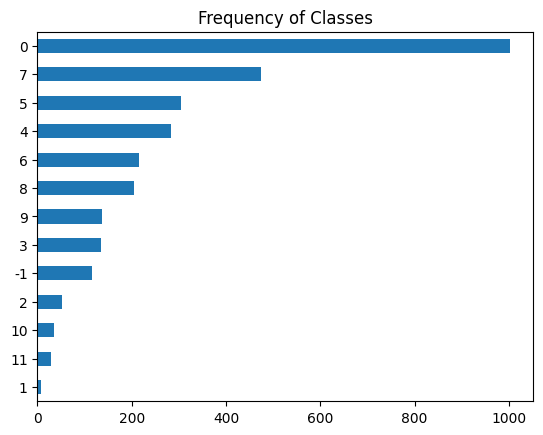

In [6]:
import matplotlib.pyplot as plt

df["final_vote"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

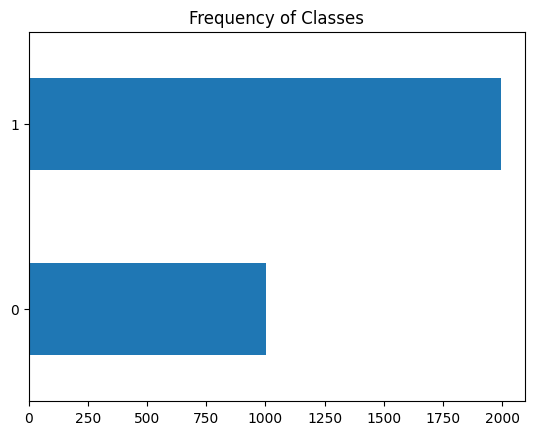

In [7]:
df["final_vote"] = df["final_vote"].apply(lambda x: int(x != 0))
df["final_vote"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = df[["text", "final_vote"]].rename(columns={"final_vote": "label"})

# Split Data into 80% train, 10% validation, 10% test
train_data, test_val_data = train_test_split(data, test_size=0.2, random_state=12, stratify=data['label'])

test_data, val_data = train_test_split(test_val_data, test_size=0.5, random_state=12, stratify=test_val_data['label'])

print(f"Training set: {len(train_data)}")
print(f"Testing set: {len(test_data)}")
print(f"Validation set: {len(val_data)}")


Training set: 2396
Testing set: 300
Validation set: 300


# Text Classification

In [9]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)


stationary_dataset = DatasetDict()

stationary_dataset['train'] = train_dataset
stationary_dataset['validation'] = val_dataset
stationary_dataset['test'] = test_dataset

In [10]:
stationary_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 2396
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 300
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 300
    })
})

In [11]:
train_dataset[0]

{'text': "trying to read a bit today while my wife's here, to get some distraction and get back on the positivity train",
 'label': 1,
 '__index_level_0__': 883}

In [12]:
print(train_dataset[:5])

{'text': ["trying to read a bit today while my wife's here, to get some distraction and get back on the positivity train", "absolutely dreading core day today i know i'm gonna end up enjoying myself but i'm still feeling kinda sleepy and i go in like an hour", 'i know i need to start studying but i am so lazy', 'Today the whole world came crashing down on me. So I grabbed a couple of drawing pins and put the map back up on the wall.', 'Say good morning to my Wishtender'], 'label': [1, 1, 1, 0, 1], '__index_level_0__': [883, 1135, 2574, 1813, 2255]}


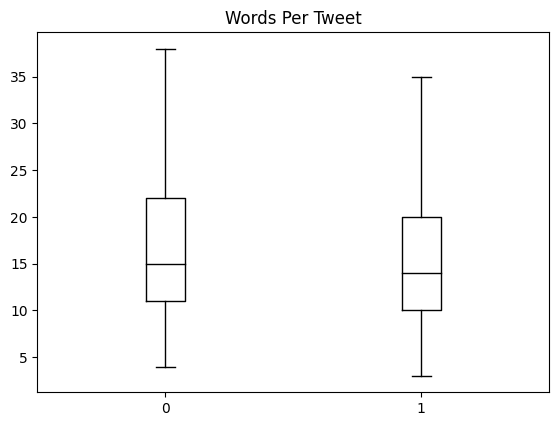

In [13]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="final_vote", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

## Tokenization

In [14]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [15]:
# Print Tokenizer Info
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
d = sorted(tokens2ids, key=lambda x : x[-1])
tokens = pd.DataFrame(d, columns=["Special Token", "Special Token ID"])

print(f"============={tokenizer.name_or_path}=============")
display(tokens.T)
print(f"\nVocabulary Size: {tokenizer.vocab_size}")
print(f"Max length: {tokenizer.model_max_length}")
print(f"Input Names: {tokenizer.model_input_names}")

=============distilbert-base-uncased=============


,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103



Vocabulary Size: 30522
Max length: 512
Input Names: ['input_ids', 'attention_mask']


In [16]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [17]:
stationary_dataset_encoded = stationary_dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/2396 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

By default, the `map()` method operates individually on every example in the corpus, so setting `batched=True` will encode the tweets in batches. Because we've set `batch_size=None`, our `tokenize()` function will be applied on the full dataset as a single batch. This ensures that the input tensors and attention masks have the same shape globally, and we can see that this operation has added new `input_ids` and `attention_mask` columns to the dataset:

In [18]:
print(stationary_dataset_encoded["train"].column_names)

['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask']


### Fine-Tuning Transformers

In [19]:
# hide_output
from transformers import AutoModelForSequenceClassification

num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### Training the model

In [21]:
from huggingface_hub import notebook_login

notebook_login()

In [22]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(stationary_dataset_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-stationary"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=10,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

In [23]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=stationary_dataset_encoded["train"],
                  eval_dataset=stationary_dataset_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.609800,0.521654,0.736667,0.708309
2,0.471300,0.487531,0.770000,0.754859
3,0.369000,0.546049,0.763333,0.750138
4,0.291700,0.553853,0.763333,0.756278
5,0.203300,0.597595,0.776667,0.775182
6,0.160300,0.658524,0.760000,0.755026
7,0.108000,0.700727,0.766667,0.765441
8,0.077600,0.818287,0.766667,0.755307
9,0.057700,0.827452,0.763333,0.754391
10,0.052800,0.823708,0.763333,0.757165


In [30]:
# hide_output
preds_output = trainer.predict(stationary_dataset_encoded["test"])

In [25]:
preds_output.metrics

{'test_loss': 0.7929611802101135,
 'test_accuracy': 0.7633333333333333,
 'test_f1': 0.7589369070147659,
 'test_runtime': 0.4446,
 'test_samples_per_second': 674.732,
 'test_steps_per_second': 11.246}

It also contains the raw predictions for each class. We can decode the predictions greedily using `np.argmax()`. This yields the predicted labels and has the same format as the labels returned by the Scikit-Learn models in the feature-based approach:

In [26]:
import numpy as np
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(stationary_dataset["test"]["label"])

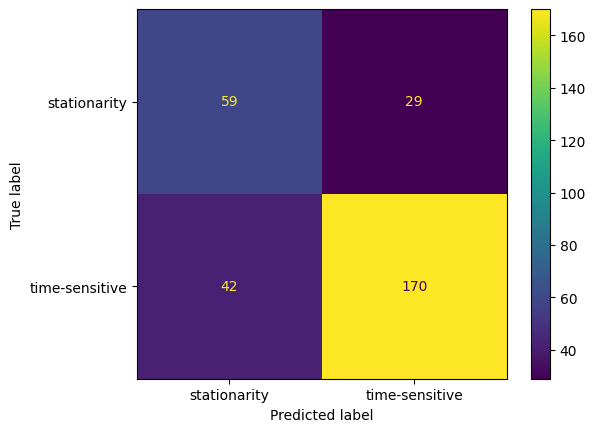

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = ["stationarity",  "time-sensitive"]

cm = confusion_matrix(y_preds, y_valid, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot()
plt.show()

<Axes: >

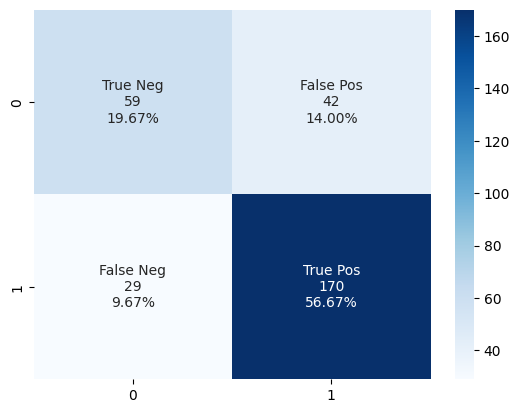

In [28]:
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_valid, y_preds)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray([labels]).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [31]:
#hide_output
trainer.push_to_hub(commit_message="Training completed!")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1700510737.d4676436758b.176.0:   0%|          | 0.00/9.76k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

'https://huggingface.co/Luggi/distilbert-base-uncased-finetuned-stationary/tree/main/'

## Inference

In [32]:
from transformers import pipeline

classifier = pipeline("text-classification", model="Luggi/distilbert-base-uncased-finetuned-stationary")


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [33]:
text =  "The quick brown fox jumps over the lazy dog."

classifier(text)

[{'label': 'LABEL_0', 'score': 0.94580078125}]

In [34]:
text =  "I need to wake up at 7:30 am tomorrow."

classifier(text)

[{'label': 'LABEL_1', 'score': 0.9969077706336975}]